In [85]:
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

import os
import json
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from datasets import CaptionDataset
from models import Encoder, Attention, DecoderWithAttention
from caption import caption_image_beam_search, visualize_att, _read_image, caps_to_string

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 01 Caption generation

Let's now try to use a pre-trained model to generate some captions.

## 01-1 Load model

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
DATA_DIR = '/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/coco/'
checkpoint_file = os.path.join(DATA_DIR, 'BEST_checkpoint_coco.pth.tar')

In [39]:
checkpoint = torch.load(checkpoint_file, map_location=str(device))

In [40]:
type(checkpoint), checkpoint.keys(), checkpoint['epoch']

(dict,
 dict_keys(['epoch', 'epochs_since_improvement', 'bleu-4', 'encoder', 'decoder', 'encoder_optimizer', 'decoder_optimizer']),
 18)

In [41]:
decoder = checkpoint['decoder']

In [42]:
decoder.eval();

In [43]:
encoder = checkpoint['encoder']

In [44]:
encoder.eval();

## 01-2 Load word map

In [45]:
json_file = os.path.join(DATA_DIR, 'WORDMAP_coco.json')

In [46]:
with open(json_file, 'r') as j:
    word_map = json.load(j)

In [47]:
rev_word_map = {v: k for k, v in word_map.items()}

In [48]:
len(rev_word_map), list(rev_word_map.items())[:3]

(9490, [(1, 'a'), (2, 'man'), (3, 'with')])

In [49]:
rev_word_map[9488]

'<start>'

## 01-3 Generate caption

In [50]:
image_path = os.path.join(DATA_DIR, 'boat.jpg')

In [51]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

In [52]:
alphas = torch.FloatTensor(alphas)

/Volumes/GoogleDrive/My Drive/colab/projects/image_caption/caption.py:221: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)


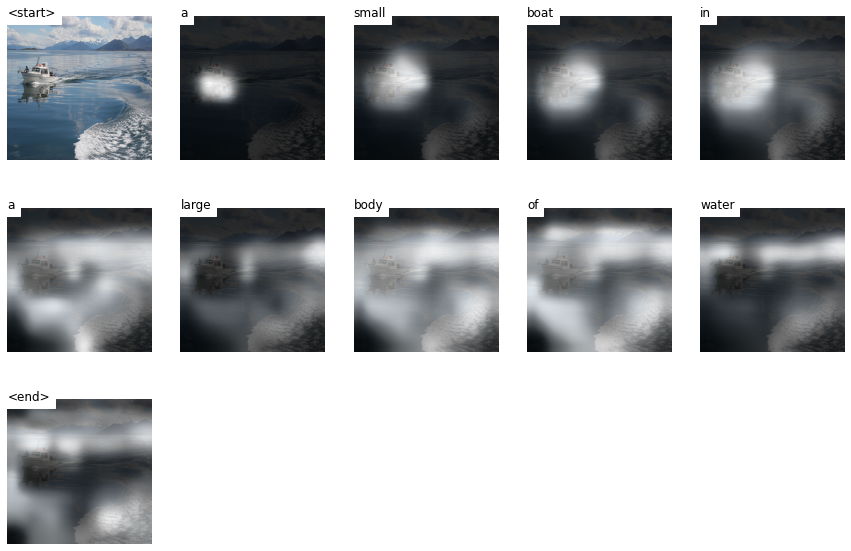

In [53]:
plt.figure(figsize=(15,10))
visualize_att(image_path, seq, alphas, rev_word_map)

# 02 `caption_image_beam_search()`

## 02-1 Variables

First of all let's have a look into some variables. First some tensors:
- `k_prev_words`: `(3, 1)`; contains indicies of words (in our vocabulary) that are combined into the generated sequence;
- `seqs`: `(3, 1) ... (3, 11) ...`; contains indicies of `k` sequences including the one that we generate;
- `top_k_scores` `(3, 1)`; contains `k` top scores;

And now some lists:
- `complete_seqs`;
- `complete_seqs_scores`;

These 2 variables are used outside of the main loop (Step 5) to get the final sequence. We get max index `i_max` from `complete_seqs_scores` (as `argmax`) and take our generated sequence as `complete_seqs[i_max]`.

### 01 `k_prev_words`

`k_prev_words` has shape `(3, 1)` (here we ignore shape reducing). As we may see below it contains all the words that are eventually included in the generated caption. 

In [67]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

step:1 k_prev_words:tensor([9488, 9488, 9488]) ['<start>', '<start>', '<start>']
step:2 k_prev_words:tensor([ 1, 14, 60]) ['a', 'the', 'an']
step:3 k_prev_words:tensor([336,  46,   7]) ['boat', 'white', 'small']
step:4 k_prev_words:tensor([ 35, 336, 336]) ['is', 'boat', 'boat']
step:5 k_prev_words:tensor([35, 32, 35]) ['is', 'in', 'is']
step:6 k_prev_words:tensor([14,  1, 32]) ['the', 'a', 'in']
step:7 k_prev_words:tensor([ 14,  45, 355]) ['the', 'large', 'water']
step:8 k_prev_words:tensor([1198,  355,    3]) ['body', 'water', 'with']
step:9 k_prev_words:tensor([17,  1,  3]) ['of', 'a', 'with']
step:10 k_prev_words:tensor([355,   1, 336]) ['water', 'a', 'boat']
step:11 k_prev_words:tensor([ 3, 32]) ['with', 'in']
step:12 k_prev_words:tensor([ 1, 14]) ['a', 'the']
step:13 k_prev_words:tensor([ 29, 355]) ['background', 'water']


In [68]:
seq

[9488, 1, 7, 336, 32, 1, 45, 1198, 17, 355, 9489]

In [69]:
' '.join([rev_word_map[i] for i in seq])

'<start> a small boat in a large body of water <end>'

### 02 `seqs`

As we may see `seqs` contains all the options including the final one. It actually contains integers, we just printed here words for clarity. So we somehow supply those indicies from `k_prev_words` to `seqs`.

In [74]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

step:1
<start>
<start>
<start>

step:2
<start> a
<start> the
<start> an

step:3
<start> a boat
<start> a white
<start> a small

step:4
<start> a boat is
<start> a white boat
<start> a small boat

step:5
<start> a small boat is
<start> a small boat in
<start> a white boat is

step:6
<start> a small boat in the
<start> a small boat in a
<start> a small boat is in

step:7
<start> a small boat is in the
<start> a small boat in a large
<start> a small boat in the water

step:8
<start> a small boat in a large body
<start> a small boat is in the water
<start> a small boat in the water with

step:9
<start> a small boat in a large body of
<start> a small boat in the water with a
<start> a small boat is in the water with

step:10
<start> a small boat in a large body of water
<start> a small boat is in the water with a
<start> a small boat in the water with a boat

step:11
<start> a small boat in a large body of water with
<start> a small boat in the water with a boat in

step:12
<start> a small 

### 03 `complete_seqs_scores` and `complete_seqs`

To get this sequence we use `complete_seqs_scores` and `complete_seqs`. After the main loop we have `k` sequences and `k` scores and choose the sequence with max score. This is step 5. As we may see our generated sequence is in fact `complete_seqs[0]` where `0` is the index of max score (`-6.02` in our case). 

In [82]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

complete_seqs_scores:[-6.02, -11.48, -11.71] i:0
complete_seqs:['<start> a small boat in a large body of water <end>', '<start> a small boat in the water with a boat in the background <end>', '<start> a small boat in the water with a boat in the water <end>']


In [86]:
caps_to_string(seq, rev_word_map)

'<start> a small boat in a large body of water <end>'

### 04 `top_k_scores`

In [90]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

top_k_scores:[0. 0. 0.]
top_k_scores:[-0.19721569 -3.0521677  -3.6467147 ]
top_k_scores:[-1.0142372 -2.6601226 -2.6948965]
top_k_scores:[-2.8077939 -2.819283  -2.922874 ]
top_k_scores:[-4.307612 -4.368802 -4.701519]
top_k_scores:[-5.109241  -5.1424904 -5.593845 ]
top_k_scores:[-5.801388  -5.8852615 -6.0753922]
top_k_scores:[-5.9738164 -6.484414  -6.884074 ]
top_k_scores:[-5.9740357 -7.268768  -7.563869 ]
top_k_scores:[-5.9773808 -8.244213  -9.573416 ]
top_k_scores:[ -9.69239  -10.212929]
top_k_scores:[-10.063251 -10.281443]
top_k_scores:[-11.465092 -11.571209]


## 02-2 Steps

### Steps 1-4

We have `k_prev_words` - this is 3 indicies in our case. For each such index we have a score in `top_k_scores`.

We supply them to `LSTM cell` to get scores for the next word. Each scores vector corresponds to a particular index. In total we have `3 * vocab_size` scores. 

So here's the key question - how can we choose the next index? Well we use *sum of scores* as a criteria. We sum a score of each index (from `top_k_scores`) with scores vector generated for it:

```python
# top_k_scores: (k, 1)
# we don't have auto broadcasting so we use expand_as()
# scores: (k, vocab_size)
scores = top_k_scores.expand_as(scores) + scores
```

We have `3 * vocab_size` scores and choose only 3. Lets try to create an example.

In [99]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

step:3
k_prev_words: boat white small
next_word_inds: is boat boat


Lets recall what we had at step 4:

```
step:4
<start> a boat is
<start> a white boat
<start> a small boat
```

### Steps 5-6

We now need to extend our `seqs` variable with the following line of code:

```python
seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
```

Lets consider an example on Step 3. 
```
step:3
<start> a boat
<start> a white
<start> a small

step:4
<start> a boat is
<start> a white boat
<start> a small boat
```

As we may see below we in fact choose `a boat` (`seqs[0]`) and add `is` and so on.

In [101]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

step:3
prev_word_inds:tensor([0, 1, 2])
next_word_inds:tensor([ 35, 336, 336]) is boat boat


### Steps 7-9

So we keep in `seqs` 3 sequences. If one of them reaches `<end>` token we don't feed it to `LSTM` anymore:

```python
k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
```

So that's all for `caption_image_beam_search()`. That was a bit involved. Lets move on to `visualize_att()`.

# 03 `visualize_att()`

First of all it's not that long as the previous function so hopefully it's going to be a bit easier to understand. Let's start with visualizing attention one more time.

## 03-1 First steps

In [102]:
image_path

'/Users/ilyarudyak/Library/Mobile Documents/com~apple~CloudDocs/datasets/coco/boat.jpg'

In [106]:
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map)

In [107]:
type(alphas)

list

In [108]:
alphas = torch.FloatTensor(alphas)

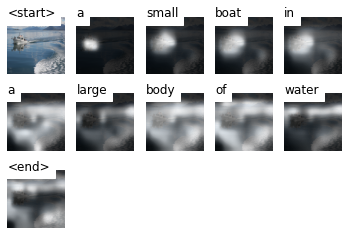

In [115]:
visualize_att(image_path, seq, alphas, rev_word_map, smooth=True)

We have to start from converting indicies to words. We may see that's in fact our caption.

In [116]:
visualize_att(image_path, seq, alphas, rev_word_map, smooth=True)

words:['<start>', 'a', 'small', 'boat', 'in', 'a', 'large', 'body', 'of', 'water', '<end>']


## 03-2 Visualizing

We have to iterate over the `words` (see above). Suppose first we don't visualize alphas - then we have a plain image with a caption. So the magic goes into visualizing our `alphas`.

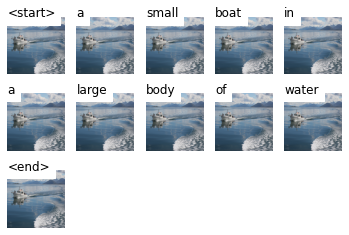

In [118]:
visualize_att(image_path, seq, alphas, rev_word_map, smooth=True)